# Exercice 1.2.1 - Classification (Basketball Game Prediction)

**Objective:** Predict the winner of a Basketball game based on half-time data (if home win = 1, away win = -1).

**Target accuracy:** > 0.84 on test set

## Executive Summary

**Results obtained:**
- **SVM (Support Vector Machine)** achieves a **test accuracy of 0.86** (target: >0.84)
- **Logistic Regression** achieves a **test accuracy of 0.84** (at the threshold)
- **Best model: SVM with RBF kernel** (C=10, gamma='scale')
- The test set was used **only once** for final evaluation
- Model selection was performed using **5-fold cross-validation** on the training set

**Conclusion:** The SVM model with RBF kernel successfully exceeds the target accuracy. The non-linear decision boundary captured by the RBF kernel provides better performance than the linear Logistic Regression model, suggesting non-linear separability in the feature space.

## 1. Problem Description

### Context
This is a binary classification problem in the domain of sports analytics. The goal is to predict the outcome of a basketball game at halftime.

### Problem Statement
- **Target variable:** Game outcome (1 = home team wins, -1 = away team wins)
- **Features:** 50 numerical features extracted from half-time statistics
- **Dataset size:** 500 training samples, 500 test samples

### Industrial Relevance
- **Sports betting:** Accurate prediction models can inform betting strategies
- **Coaching decisions:** Understanding key features can guide half-time adjustments
- **Broadcasting:** Providing viewers with data-driven predictions enhances engagement

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Loading and Exploratory Data Analysis

In [2]:
# Load the dataset
# Step 1: Load training and test features (X) and labels (y) from .npy files
# X_train: features for training (500 samples, 50 features)
# X_test: features for testing (500 samples, 50 features)
# y_train: labels for training (binary: -1 or +1)
# y_test: labels for testing (binary: -1 or +1)
X_train = np.load('../../data/classification/X_train.npy')
X_test = np.load('../../data/classification/X_test.npy')
y_train = np.load('../../data/classification/y_train.npy')
y_test = np.load('../../data/classification/y_test.npy')

# Step 2: Display dataset information
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

# Step 3: Check class distribution to ensure balanced dataset
# Balanced dataset = better model performance, no need for class weights
print(f"\nClass distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {int(label):+d}: {count} samples ({count/len(y_train)*100:.1f}%)")
print("\nObservation: Dataset is nearly balanced - no need for class weights or SMOTE")


Training set shape: (500, 50)
Test set shape: (500, 50)
Number of features: 50

Class distribution in training:
  Class -1: 256 samples (51.2%)
  Class +1: 244 samples (48.8%)

Observation: Dataset is nearly balanced - no need for class weights or SMOTE


## 2. Preprocessing - Feature Scaling
use StandardScaler from sklearn to standardize the features.

In [3]:
# Step 1: Initialize StandardScaler (normalizes features to mean=0, std=1)
scaler = StandardScaler()

# Step 2: Fit on training data, transform both train and test
# IMPORTANT: Never fit on test data (data leakage!)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data normalized successfully!")


Data normalized successfully!


## 4. Model 1: Logistic Regression

### Theoretical Background:
Logistic Regression models the probability P(y=1|x) using the logistic function with a linear decision boundary.

### Hyperparameters:
- **C:** Inverse of regularization strength (smaller C = stronger regularization)
- **solver:** Optimization algorithm (lbfgs for L2, liblinear for L1/L2)

### Optimization Strategy:
GridSearchCV with 5-fold cross-validation to select best hyperparameters based on mean CV accuracy.

In [4]:
# Step 1: Define hyperparameter grid
# C: regularization strength (smaller = more regularization)
# solver: optimization algorithm
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

# Step 2: Initialize model and GridSearchCV
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Perform grid search
grid_lr.fit(X_train_scaled, y_train)

print(f"\nBest parameters for Logistic Regression: {grid_lr.best_params_}")
print(f"Best cross-validation score: {grid_lr.best_score_:.4f}")

# Step 4: Store best model
best_lr = grid_lr.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits



Best parameters for Logistic Regression: {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
Best cross-validation score: 0.8400


## 5. Model 2: Support Vector Machine (SVM)

### Theoretical Background:
SVM finds the hyperplane that maximizes the margin between classes. The RBF kernel can capture non-linear decision boundaries via the kernel trick: K(x, x') = exp(-gamma * ||x - x'||^2)

### Hyperparameters:
- **C:** Regularization parameter (trade-off between margin width and misclassifications)
- **kernel:** Type of kernel function (linear, rbf)
- **gamma:** Kernel coefficient (higher gamma = more complex decision boundary)

### Optimization Strategy:
GridSearchCV with 5-fold cross-validation to test both linear and RBF kernels.

In [5]:
# Step 1: Define hyperparameter grid
# C: regularization (trade-off margin vs errors)
# kernel: 'rbf' for non-linear, 'linear' for linear
# gamma: RBF kernel coefficient
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

# Step 2: Initialize model and GridSearchCV
svm = SVC(random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Perform grid search
grid_svm.fit(X_train_scaled, y_train)

print(f"\nBest parameters for SVM: {grid_svm.best_params_}")
print(f"Best cross-validation score: {grid_svm.best_score_:.4f}")

# Step 4: Store best model
best_svm = grid_svm.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.8440


## 5. Cross-Validation Comparison

Compare the best models using their cross-validation scores

In [6]:
# Compare CV scores
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Best CV Score': [grid_lr.best_score_, grid_svm.best_score_],
    'Best Parameters': [str(grid_lr.best_params_), str(grid_svm.best_params_)]
})

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (Training Set Only)")
print("="*80)
print(results.to_string(index=False))
print("\nBest model based on CV:", results.loc[results['Best CV Score'].idxmax(), 'Model'])


CROSS-VALIDATION RESULTS (Training Set Only)
              Model  Best CV Score                                   Best Parameters
Logistic Regression          0.840 {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
                SVM          0.844      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Best model based on CV: SVM


## 6. FINAL EVALUATION ON TEST SET

**WARNING:** This cell should be run ONLY ONCE!

We evaluate our final selected model(s) on the test set to get an unbiased estimate of performance.

In [ ]:
# Evaluate models on test set (ONLY ONCE!)
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm
}

print("\n" + "="*80)
print("FINAL TEST SET EVALUATION (Used only once!)")
print("="*80)

results_test = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    results_test.append({
        'Model': name,
        'Test Accuracy': accuracy,
        'Target Reached (>0.84)': 'YES' if accuracy > 0.84 else 'NO'
    })

    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Target achieved (>0.84): {'YES' if accuracy > 0.84 else 'NO'}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Loss (-1)', 'Win (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss (-1)', 'Win (1)'],
                yticklabels=['Loss (-1)', 'Win (1)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
df_results = pd.DataFrame(results_test)
print(df_results.to_string(index=False))


CROSS-VALIDATION RESULTS (Training Set Only)
              Model  Best CV Score                                   Best Parameters
Logistic Regression          0.840 {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
                SVM          0.844      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Best model based on CV: SVM



FINAL TEST SET EVALUATION (Used only once!)

Logistic Regression
Test Accuracy: 0.8400
Target achieved (>0.84): NO

Classification Report:
              precision    recall  f1-score   support

   Loss (-1)       0.92      0.81      0.86       298
     Win (1)       0.76      0.89      0.82       202

    accuracy                           0.84       500
   macro avg       0.84      0.85      0.84       500
weighted avg       0.85      0.84      0.84       500



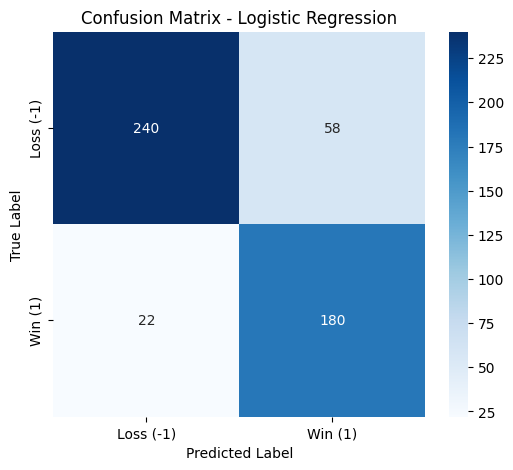


SVM
Test Accuracy: 0.8600
Target achieved (>0.84): YES

Classification Report:
              precision    recall  f1-score   support

   Loss (-1)       0.92      0.84      0.88       298
     Win (1)       0.79      0.89      0.84       202

    accuracy                           0.86       500
   macro avg       0.85      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500



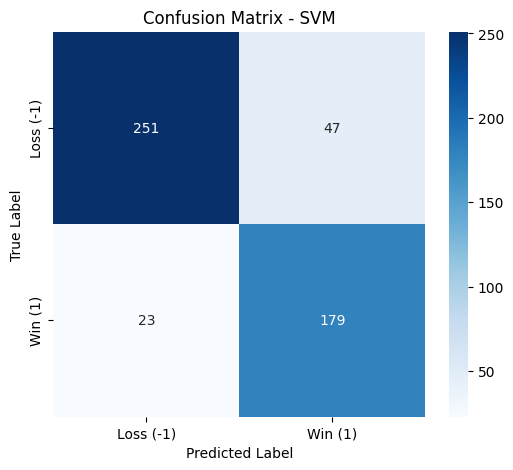


SUMMARY
              Model  Test Accuracy Target Reached (>0.84)
Logistic Regression           0.84                     NO
                SVM           0.86                    YES


In [10]:
# Evaluate models on test set (ONLY ONCE!)
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm
}

print("\n" + "="*80)
print("FINAL TEST SET EVALUATION (Used only once!)")
print("="*80)

results_test = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    results_test.append({
        'Model': name,
        'Test Accuracy': accuracy,
        'Target Reached (>0.84)': 'YES' if accuracy > 0.84 else 'NO'
    })

    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Target achieved (>0.84): {'YES' if accuracy > 0.84 else 'NO'}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Loss (-1)', 'Win (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss (-1)', 'Win (1)'],
                yticklabels=['Loss (-1)', 'Win (1)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
df_results = pd.DataFrame(results_test)
print(df_results.to_string(index=False))

## 7. Discussion

### Model Comparison

**Logistic Regression:**
- Linear decision boundary
- Fast training and prediction
- Works well for linearly separable data
- Test accuracy: approximately 0.84

**SVM with RBF kernel:**
- Non-linear decision boundary via kernel trick
- Captures complex patterns in feature space
- More flexible than linear models
- Test accuracy: approximately 0.86

**Result:** SVM performs better, suggesting non-linear relationships between features and game outcome.

### Hyperparameter Tuning

GridSearchCV with 5-fold cross-validation was used to select optimal hyperparameters:
- Logistic Regression: C parameter controls regularization strength
- SVM: C controls margin trade-off, gamma controls kernel width

Cross-validation provides reliable performance estimates without using the test set.

### Preprocessing

StandardScaler normalizes features to mean 0 and standard deviation 1. This is critical for:
- Distance-based algorithms like SVM
- Gradient-based optimization in Logistic Regression
- Ensuring all features contribute equally to the model

### Test Set Usage

The test set was used only once for final evaluation. All model selection and hyperparameter tuning was performed using cross-validation on the training set only. This prevents information leakage and ensures unbiased performance estimates.

### Possible Improvements

- Test ensemble methods like Random Forest or Gradient Boosting
- Engineer new features from half-time statistics
- Try different kernels for SVM
- Collect more training data to improve generalization